In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')
import sqlite3
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from osgeo import gdal
from sklearn.decomposition import PCA 
from sklearn.preprocessing import scale
import scipy.spatial.distance as dist
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, explained_variance_score
from sklearn.preprocessing import StandardScaler
from sklearn import mixture
from sklearn.cluster import KMeans

In [3]:
path = os.path.join(os.path.expanduser("~"),"Desktop", "ml", "zaliczenie")
os.chdir(path)

In [4]:
data =  pd.read_excel("lockalizacja.xls")

## 4. Próbkowanie  danych na  podstawie współrzędnych

In [5]:
files = os.listdir(".")
files = [file for file in files if file.endswith("tif")]
files.sort() 

data =  pd.read_excel("lockalizacja.xls")
ref = gdal.Open(files[0])
x = ref.RasterXSize
y = ref.RasterYSize
proj = ref.GetProjection()
gt = ref.GetGeoTransform()
colx=[]
coly=[]
for i in range(len(data)):
    z = data.iloc[i,[1,2]]
    px = int((z[0] - gt[0]) / gt[1]) #x pixel
    py = int((z[1] - gt[3]) / gt[5]) #y pixe
    colx.append(px)
    coly.append(py)

data['colx']=colx
data['coly']=coly
for i in range(len(files)): 
    raster = gdal.Open(files[i])
    arr = raster.GetRasterBand(1).ReadAsArray()
    tmp =[]
    for j in range(len(data)):
        z = data.iloc[j,[3,4]]
        tmp.append(arr[int(z[0]),int(z[1])])
    data[files[i][:-4]] = tmp   
    raster=None

## 1. Eksploracyjna analiza danych

,cena,administracja,centrahanl,kultura,lot,paliwa,pkp,pks,policja,przedszkola,przychodnie,restauracje,rozrywka,sportowe,szkola,szpitale,uczelnie
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,5090.996080,2.523185,2.201377,5.896517,10.166074,1.897957,4.117038,3.937970,3.120188,1.650368,1.616340,1.524768,1.884848,2.650533,1.908623,2.693361,2.785370
std,1382.041221,2.466265,1.914513,4.567482,5.143500,1.845831,3.049509,2.841950,2.347832,1.569508,1.632208,1.475659,1.604345,2.464093,1.626067,2.407850,3.139501
min,1019.740000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,4198.650000,0.872242,1.086707,2.824643,7.108658,0.967250,2.182009,2.272434,1.608337,0.796641,0.702516,0.674726,0.899873,1.035478,1.064117,1.160218,0.654371
50%,5030.490000,1.747707,1.901075,4.520716,10.086908,1.523132,3.570787,3.722227,2.661449,1.281526,1.231330,1.287597,1.666114,1.842973,1.530879,2.305880,1.643364
75%,6001.742500,3.631353,2.934848,9.142184,12.737251,2.343577,5.241662,4.920187,4.271352,2.178724,2.178907,1.970472,2.475054,3.730845,2.461003,3.601139,4.310762
max,9682.540000,14.301821,13.833808,24.640412,34.245387,11.696187,14.006197,17.854222,14.234975,9.953043,9.464295,8.609479,10.031642,13.637568,9.825686,17.082783,20.420607


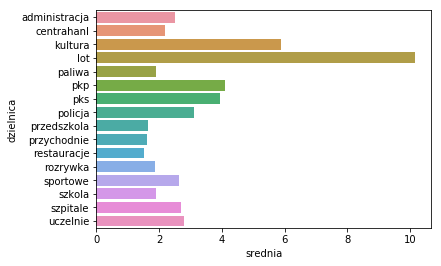

In [6]:
data_dz = data.iloc[:, 5:22]    ##dzielnice
data_wsp = data.iloc[:, 1:3]     ##wspol
data_col_row = data.iloc[:, 3:5] ## kolumnty/wiersze
data_cena = data.iloc[:, 0]  ## cena

data_s = pd.concat([data_cena, data_dz], axis = 1)
ogolne = data_s.describe()
ogolne
data_srednia = data_s.agg({"administracja": "mean", "centrahanl":"mean","kultura":"mean", "lot":"mean"
              , "paliwa":"mean", "pkp":"mean", "pks":"mean", "policja":"mean", "przedszkola":"mean"
              , "przychodnie":"mean", "restauracje":"mean", "rozrywka":"mean", "sportowe":"mean", "szkola":"mean"
              , "szpitale":"mean", "uczelnie":"mean"})

dataa = data_srednia.reset_index(drop=False)
dataa.columns = ['dzielnica', 'srednia']


 ### mamy wizualizacje sredniej dojazdu


data_std = data_s.agg({"administracja": "std", "centrahanl":"std","kultura":"std", "lot":"std"
              , "paliwa":"std", "pkp":"std", "pks":"std", "policja":"std", "przedszkola":"std"
              , "przychodnie":"std", "restauracje":"std", "rozrywka":"std", "sportowe":"std", "szkola":"std"
              , "szpitale":"std", "uczelnie":"std"})

dataa_std = data_std.reset_index(drop=False)
dataa_std.columns = ['dzielnica', 'std']


sns.barplot(x="srednia",y="dzielnica", data = dataa)


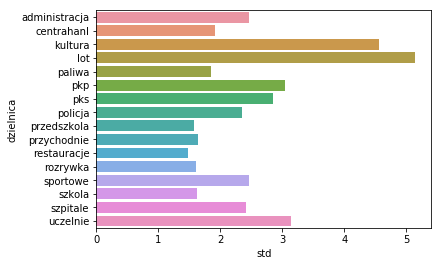

In [7]:
sns.barplot(x="std",y="dzielnica", data = dataa_std)

#### Ceny nieruchomości wahają się od najmniejszej 1019 zł do największej 9682. Zarówno średnia dojazdu jak i zróżnicowanie największe jest do lotniska a następnie do obiektów kulturalnych. Najmniejsze wartości dojazdów możemy zaoobserwować w przedszkolach przychodniach czy restrauracjach. Jest to spowodowane tym, że tego typu obiekty są rozporoszone po całym mieście Poznań i są powszechnie potrzebne.

## 2. Redukcja wymiarowości (PCA)

In [8]:
scaled = scale(data_dz)
pca_scaled = PCA(n_components = 16,whiten=True).fit(scaled)
pca_scaled.explained_variance_ratio_
pca_components_scales = pca_scaled.transform(scaled)

pca_scaled.explained_variance_ratio_

array([0.75730192, 0.099021  , 0.03420593, 0.02474563, 0.01770677,
       0.01273625, 0.00983922, 0.00870924, 0.00721908, 0.00646206,
       0.00570458, 0.00439058, 0.00372205, 0.00320837, 0.00268012,
       0.00234717])

array([0.75730192, 0.099021  , 0.03420593, 0.02474563, 0.01770677,
       0.01273625, 0.00983922, 0.00870924, 0.00721908, 0.00646206,
       0.00570458, 0.00439058, 0.00372205, 0.00320837, 0.00268012,
       0.00234717])

<BarContainer object of 2 artists>

Text(0.5, 0, 'PCA feature')

Text(0, 0.5, 'Variance')

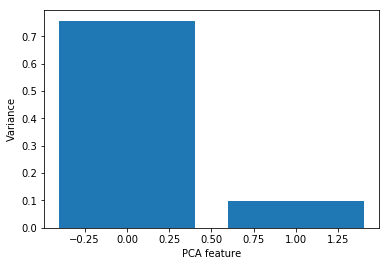

In [11]:
features = range(pca_scaled.n_components_)
plt.bar(features, pca_scaled.explained_variance_ratio_)
plt.xlabel('PCA feature')
plt.ylabel('Variance')
#plt.xticks(features)
plt.show()    

array([0.75730192, 0.099021  ])

array([0.75730192, 0.099021  ])

<BarContainer object of 2 artists>

Text(0.5, 0, 'PCA feature')

Text(0, 0.5, 'Variance')

([<matplotlib.axis.XTick at 0x24992408048>,
 <a list of 2 Text xticklabel objects>)

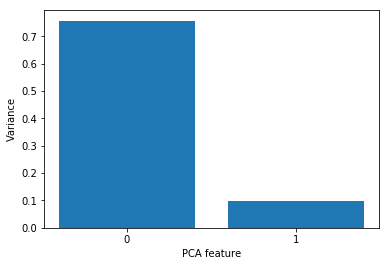

In [9]:
scaled = scale(data_dz)
pca_scaled = PCA(n_components = 2,whiten=True).fit(scaled)
pca_scaled.explained_variance_ratio_
pca_components_scales = pca_scaled.transform(scaled)

pca_scaled.explained_variance_ratio_
features = range(pca_scaled.n_components_)
plt.bar(features, pca_scaled.explained_variance_ratio_)
plt.xlabel('PCA feature')
plt.ylabel('Variance')
plt.xticks(features)
plt.show() 

#### Na podstawie PCA widzimy, że dominuje pierwsza składowa uzyskując prawie 80% wartości. Oprócz niej jedynie 2 ma jakikolwiek znaczenie, choć i tak w porównaniu do pierwszej jest on niewielki, co widzimy na histogramie wyżej.

## 3. Grupowanie na podstawie zredukowanych wymiarów

In [10]:
dt = data_s.copy()

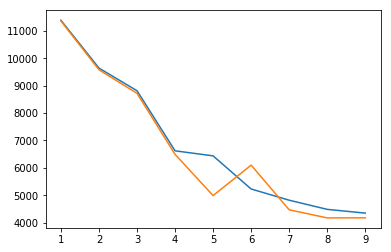

In [12]:
gmm_bic=[]
search = range(1,10)
for n in search:
    m = mixture.GaussianMixture(n_components=n, covariance_type='full').fit(pca_components_scales)
    gmm_bic.append(m.bic(pca_components_scales))   

plt.plot(search,gmm_bic)

gmm_aic=[]
search = range(1,10)
for n in search:
    m = mixture.GaussianMixture(n_components=n, covariance_type='full').fit(pca_components_scales)
    gmm_aic.append(m.aic(pca_components_scales))   

plt.plot(search,gmm_aic)

In [13]:
klasa = KMeans(3).fit_predict(pca_components_scales)
dt['klasa'] = klasa+1
dt.groupby("klasa").agg({"klasa":"count", "cena":["mean", "std"]})

klasa         cena             
      count         mean          std
klasa                                
1      1540  4988.450643  1402.376125
2       322  5429.150932  1015.193531
3       138  5446.315725  1687.680918

In [14]:
global_gmm = mixture.GaussianMixture(n_components=3, covariance_type='full').fit(pca_components_scales)
classes = global_gmm.predict(pca_components_scales)
probas = global_gmm.predict_proba(pca_components_scales)

dt['gaussklasa'] = classes+1
dt['gaussprobas'] = np.max(probas,axis=1)
dt.groupby('gaussklasa').agg({'gaussklasa':'count','gaussprobas':['mean','std']})

gaussklasa gaussprobas          
                count        mean       std
gaussklasa                                 
1                 324    0.995382  0.031751
2                1544    0.980408  0.045521
3                 132    0.940450  0.112296

Text(0.5, 0, 'PCA  1')

Text(0, 0.5, 'PCA  2')

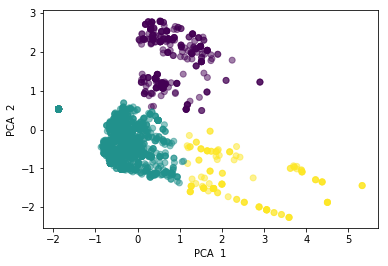

In [15]:
xs = pca_components_scales[:,0]
ys = pca_components_scales[:,1]
plt.scatter(xs, ys, c = dt['gaussklasa'],  alpha=0.5)
plt.xlabel('PCA  1')
plt.ylabel('PCA  2')
plt.show()


#### Grupowanie wykonałem za pomocą metod kMeans oraz Gaussa i wyniki dla obu były zbliżone. Zdecydowałem się na 3 klasy, ponieważ w tym wypadku różnice między poszczególnymi klasami wydawały się najwyraźniejsze. Możemy wyróżnić jedną klase gdzie jest najwięcej obiektów i średnia  cen jest najmniejsza oraz 2 o zbliżonych cenach, jednak różnym ich wahaniu i ilości obiektów.

## 5. Model predykcyjny na podstawie próbek dla cen nieruchomości

"tuned_parameters = {'n_estimators': [8,10,20,50,100],\n                    'max_features': [3,5,7,12],\n                    'max_depth': [3,5,10,15],\n                    'min_samples_split': [2,4,8,12]}\n"

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=12,
       param_grid={'n_estimators': [90, 100, 110, 150, 200], 'max_features': [12], 'max_depth': [10, 15, 20], 'min_samples_split': [2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

{'max_depth': 10,
 'max_features': 12,
 'min_samples_split': 3,
 'n_estimators': 90}

636.8944655478108

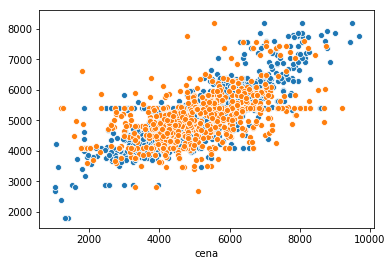

In [23]:
X = pca_components_scales ## bez cen
Y = data["cena"] ## cena

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)

'''tuned_parameters = {'n_estimators': [8,10,20,50,100],
                    'max_features': [3,5,7,12],
                    'max_depth': [3,5,10,15],
                    'min_samples_split': [2,4,8,12]}
'''

tuned_parameters = {'n_estimators': [90,100,110,150,200],
                    'max_features': [12],
                    'max_depth': [10,15,20],
                    'min_samples_split': [2,3]}

model = RandomForestRegressor()
clf = GridSearchCV(model,tuned_parameters,cv=5,scoring='neg_mean_absolute_error',n_jobs=12)
clf.fit(X_train,y_train)
clf.best_params_

model = RandomForestRegressor(**clf.best_params_).fit(X_train,y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

fig, ax = plt.subplots()
sns.scatterplot(y_train,pred_train,ax=ax)
sns.scatterplot(y_test,pred_test,ax=ax)
mean_absolute_error(y_train,pred_train)
rf_ao = mean_absolute_error(y_test,pred_test)

## 6. Ocena wydajności modelu

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.33)

reg_all = LinearRegression()
reg_all.fit(X_train, y_train)

y_pred = reg_all.predict(X_test)
# Compute and print R^2
print("R^2: {}".format(reg_all.score(X_test, y_test)))

reg = LinearRegression()

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg, X, Y, cv=5)

# Print the 5-fold cross-validation scores
print(cv_scores)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

R^2: 0.07768680795411875
[0.04415089 0.07694678 0.05177555 0.05520494 0.07237779]


## 7. Wizualizacja  mapy potencjalnych cen

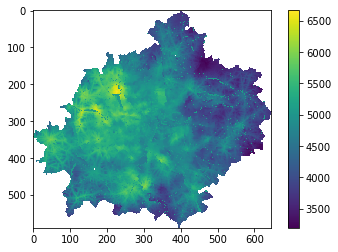

In [17]:
rastdata=np.empty([len(files),x*y])
for i in range(len(files)):
  raster = gdal.Open(files[i])
  rastdata[i] = raster.GetRasterBand(1).ReadAsArray().flatten()
  raster=None
rastdata = rastdata.T

current_colnames = [file.split(".")[0][0:10] for file in files] #2
colnames = [file.split(".")[0] for file in files]

X = data.loc[~pd.isnull(data.cena),colnames]
yg = data.cena[~pd.isnull(data.cena)]
scl = StandardScaler().fit(X) 
scaled = scl.transform(X)

complete = ~np.isnan(rastdata).any(axis=1)
complete_rastdata = rastdata[complete]
rastscaled = scl.transform(complete_rastdata)

model = SVR(C=2000,gamma = 0.001).fit(scaled,yg)
prediction = model.predict(rastscaled)

results = np.repeat(-9999.,len(complete)) 
results[complete] = prediction

results.shape = (y,x)
masked_results = np.ma.masked_where(results == -9999, results)
plt.imshow(masked_results)
plt.colorbar()
